In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Tengai.dataset import AirQuality
from Tengai.preprocessing import clustering_data,detect_outlier_zscore
from Tengai.visual_series import (lineplot_features,lineplot_resample_feature,
                                  average_generating_barplot,visualize_adfuller_results)
import statsmodels.api as sm

## Load Data

In [5]:
data = AirQuality(-8.2325,114.3576)
data

,time,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,ozone,aerosol_optical_depth,dust
0,2023-01-01 00:00:00,38.5,26.7,716.0,9.6,47.0,0.36,0.0
1,2023-01-01 01:00:00,31.1,21.4,624.0,7.8,60.0,0.34,0.0
2,2023-01-01 02:00:00,26.3,17.9,492.0,5.2,79.0,0.31,0.0
3,2023-01-01 03:00:00,24.2,16.4,347.0,2.5,98.0,0.29,0.0
4,2023-01-01 04:00:00,23.1,15.7,295.0,1.5,102.0,0.32,0.0
...,...,...,...,...,...,...,...,...
7003,2023-10-19 19:00:00,19.2,12.8,406.0,4.9,37.0,0.30,0.0
7004,2023-10-19 20:00:00,18.7,12.5,365.0,4.0,40.0,0.30,0.0
7005,2023-10-19 21:00:00,18.9,12.6,330.0,3.3,44.0,0.31,0.0
7006,2023-10-19 22:00:00,19.6,13.1,300.0,2.9,50.0,0.31,0.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7008 entries, 0 to 7007
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   time                   7008 non-null   datetime64[ns]
 1   pm10                   7008 non-null   float64       
 2   pm2_5                  7008 non-null   float64       
 3   carbon_monoxide        7008 non-null   float64       
 4   nitrogen_dioxide       7008 non-null   float64       
 5   ozone                  7008 non-null   float64       
 6   aerosol_optical_depth  7008 non-null   float64       
 7   dust                   7008 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 438.1 KB


# EDA

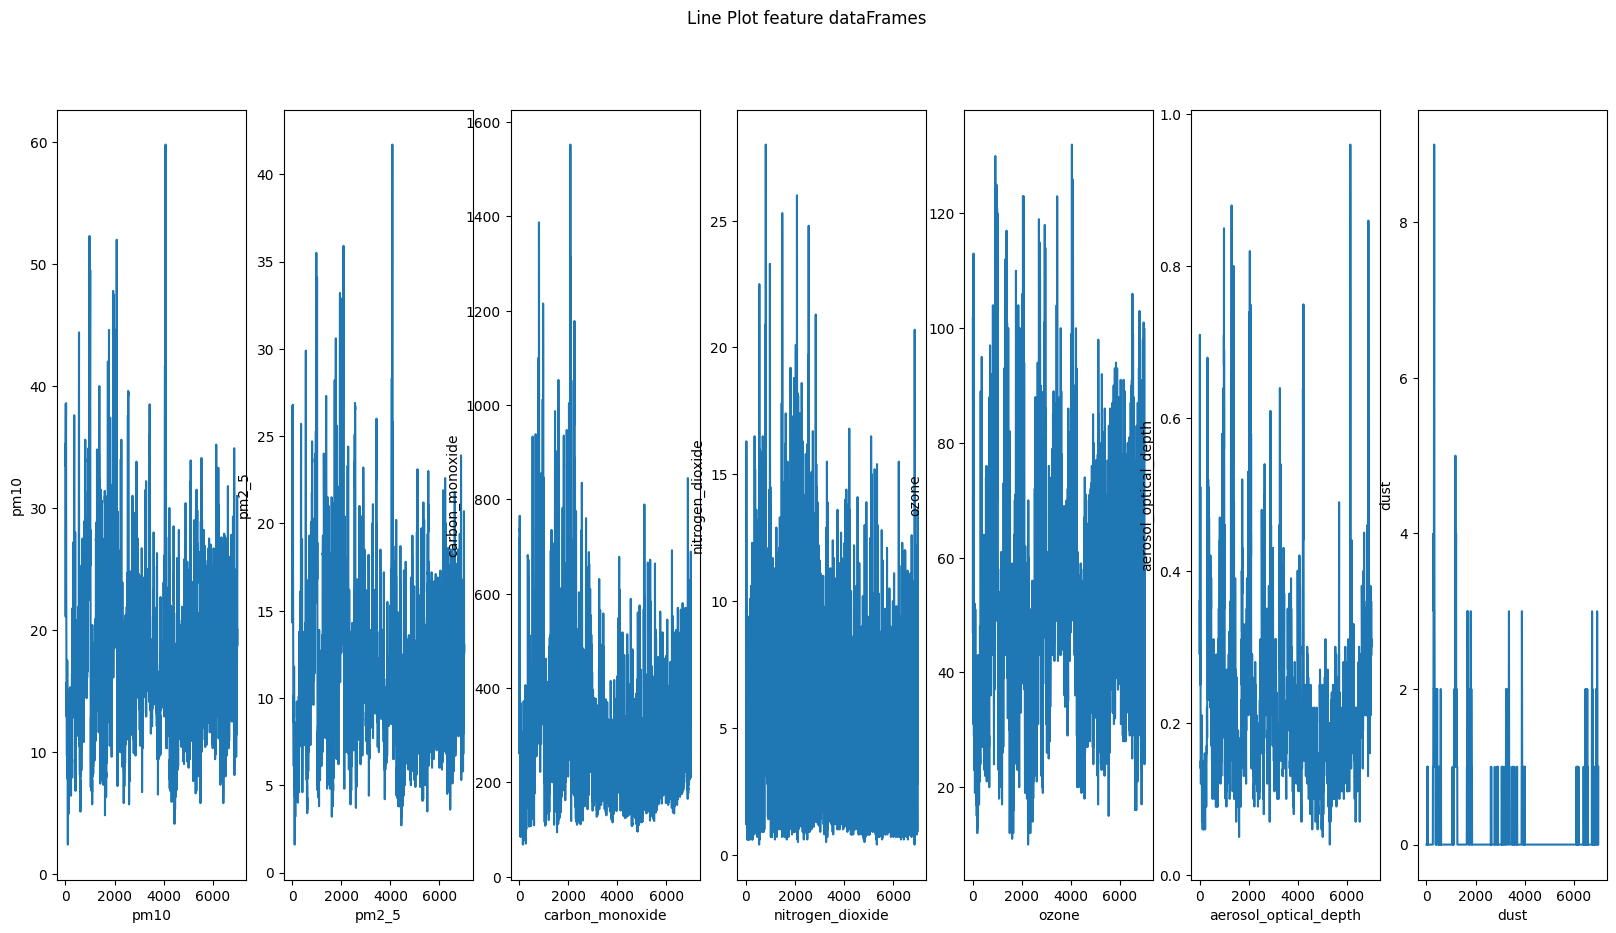

In [7]:
lineplot_features(data.iloc[:,1:],size=(20,10))

### Resample Line Plot

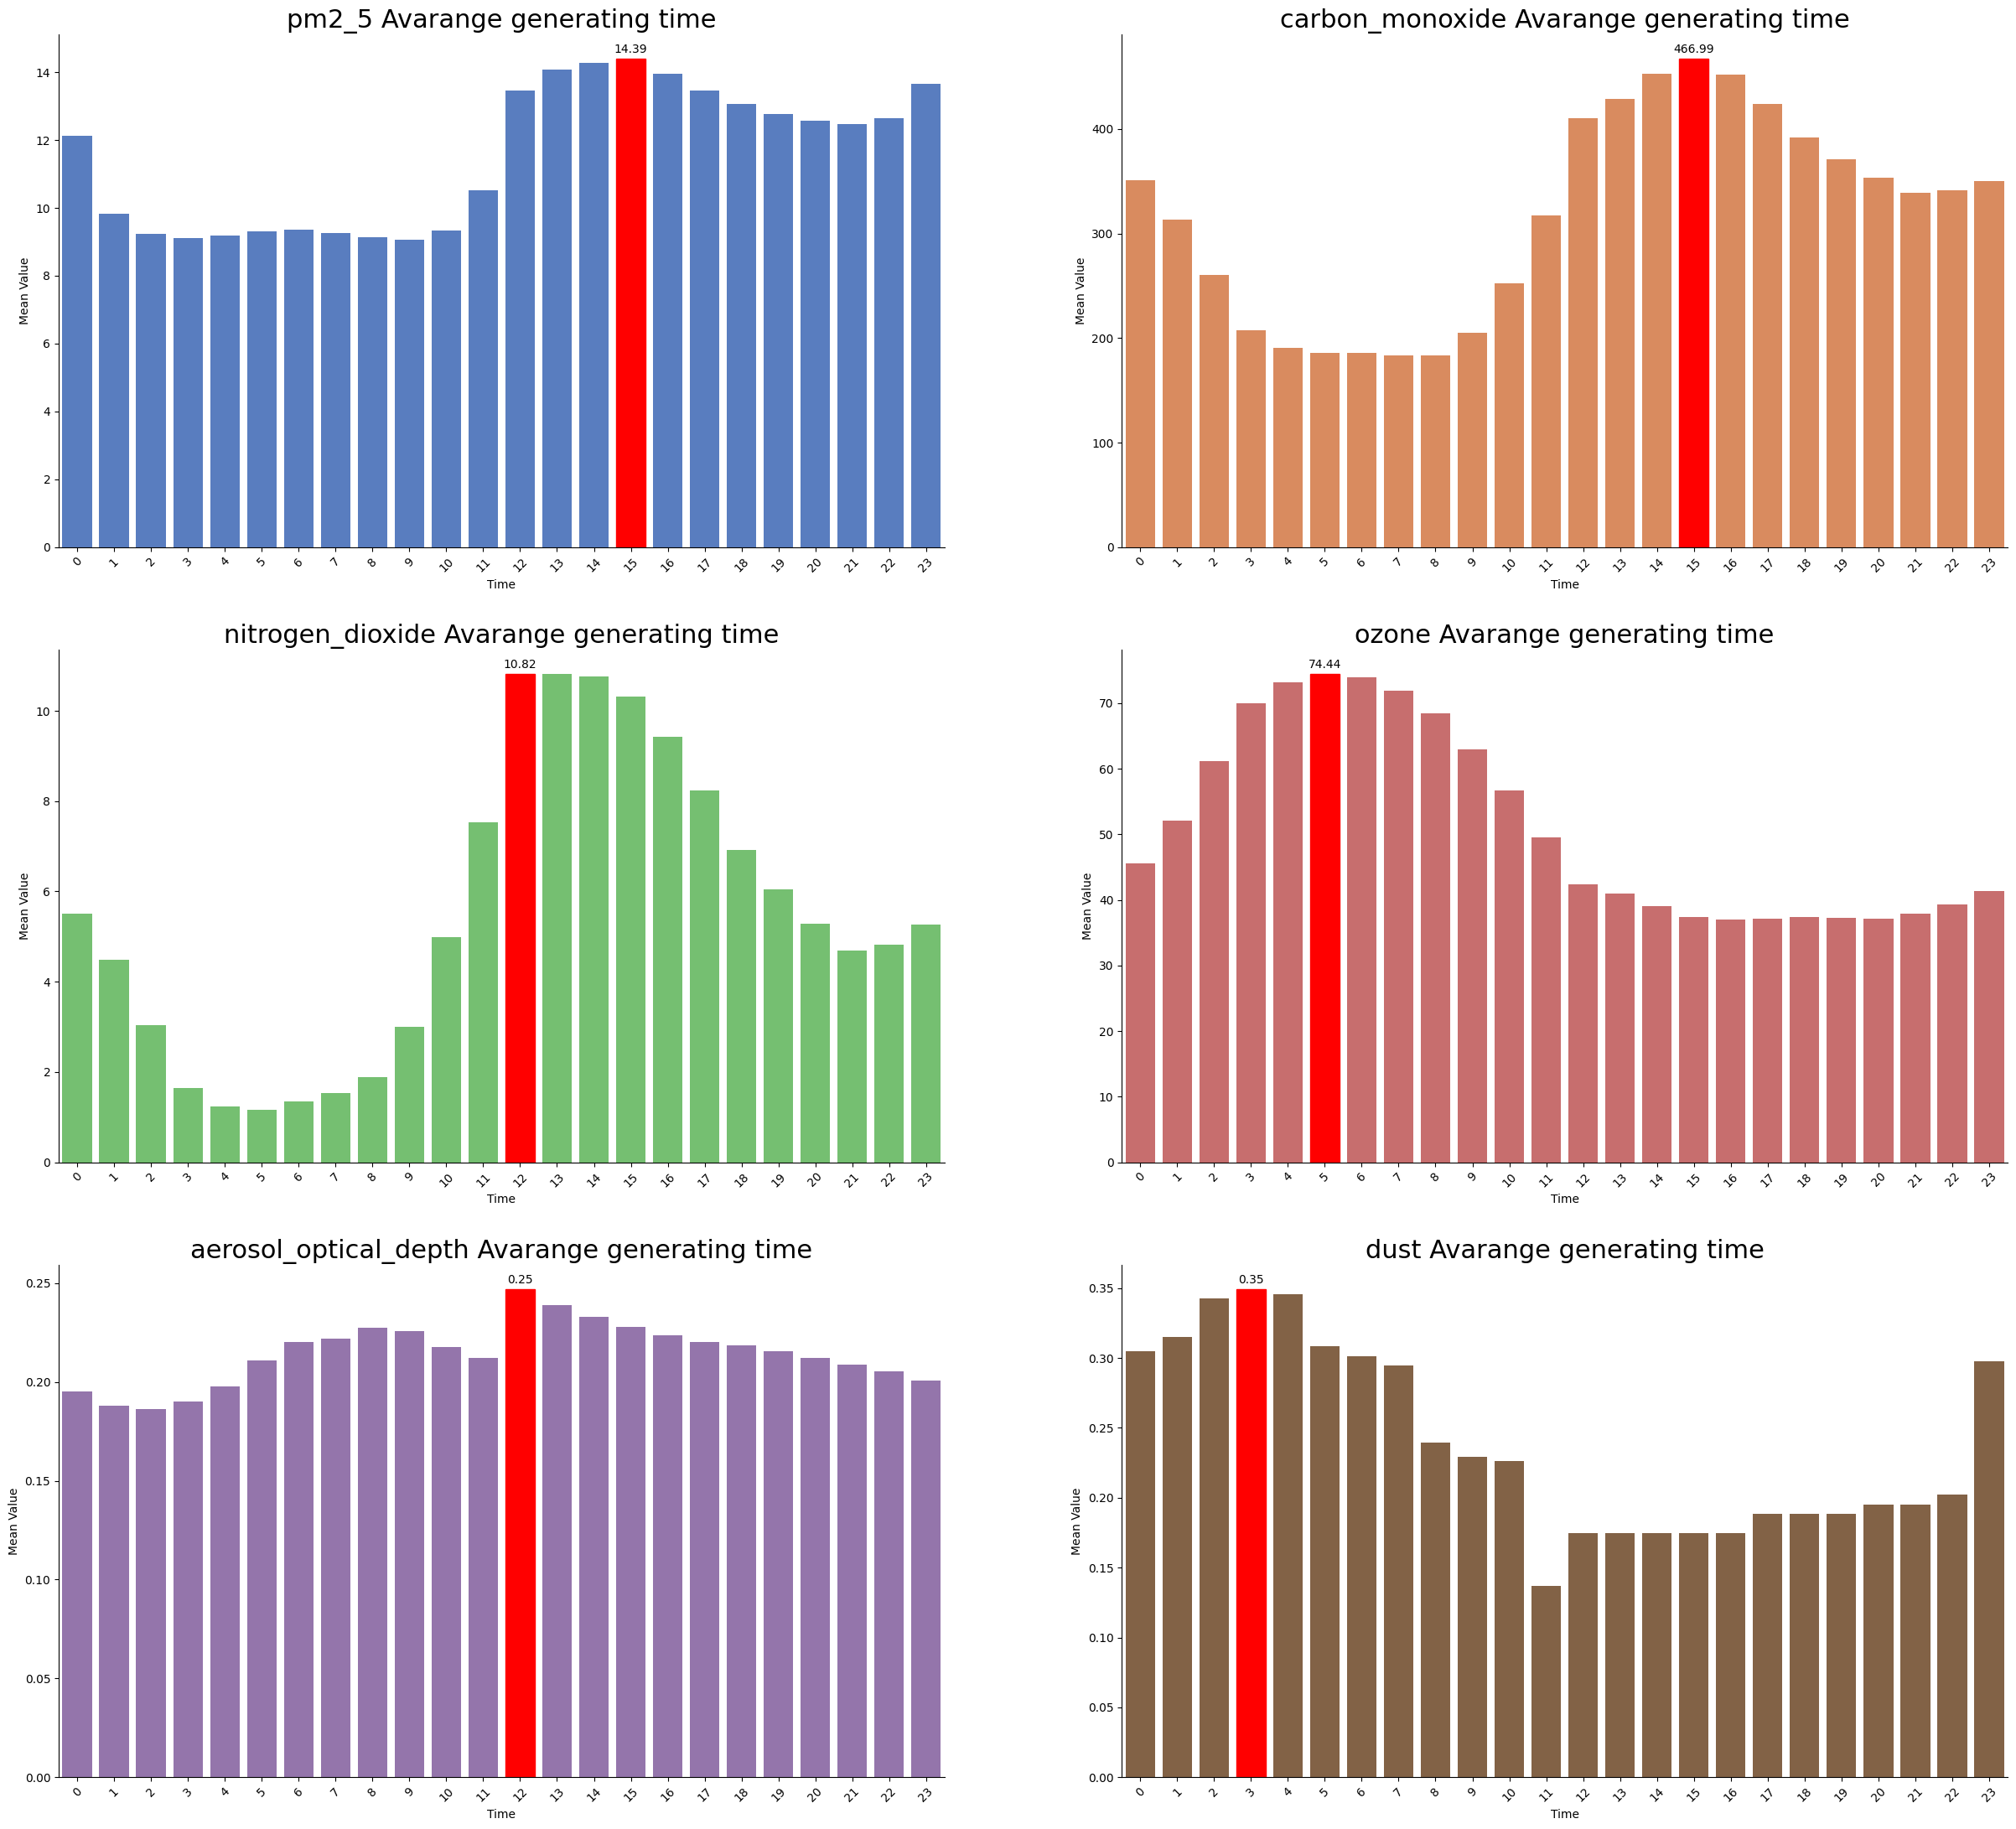

In [8]:
average_generating_barplot(data,on_feat="time")

### Linear Resample feature

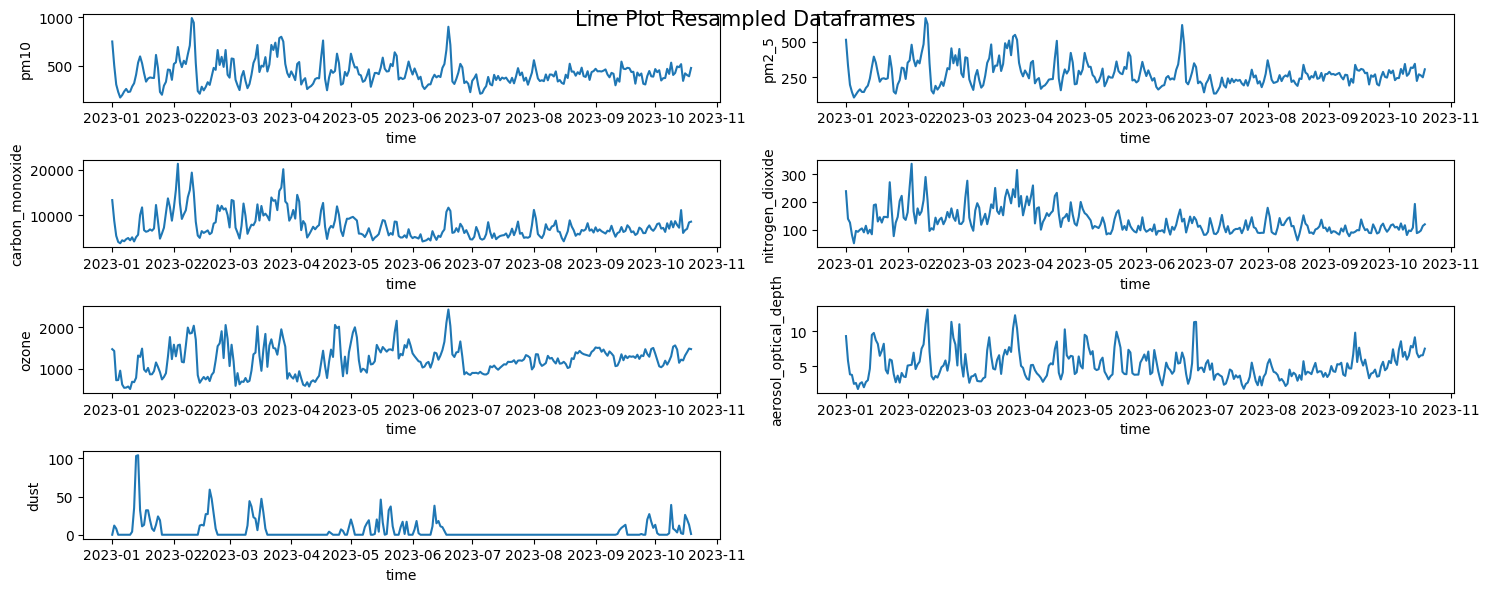

In [9]:
lineplot_resample_feature(data,"time","1D")

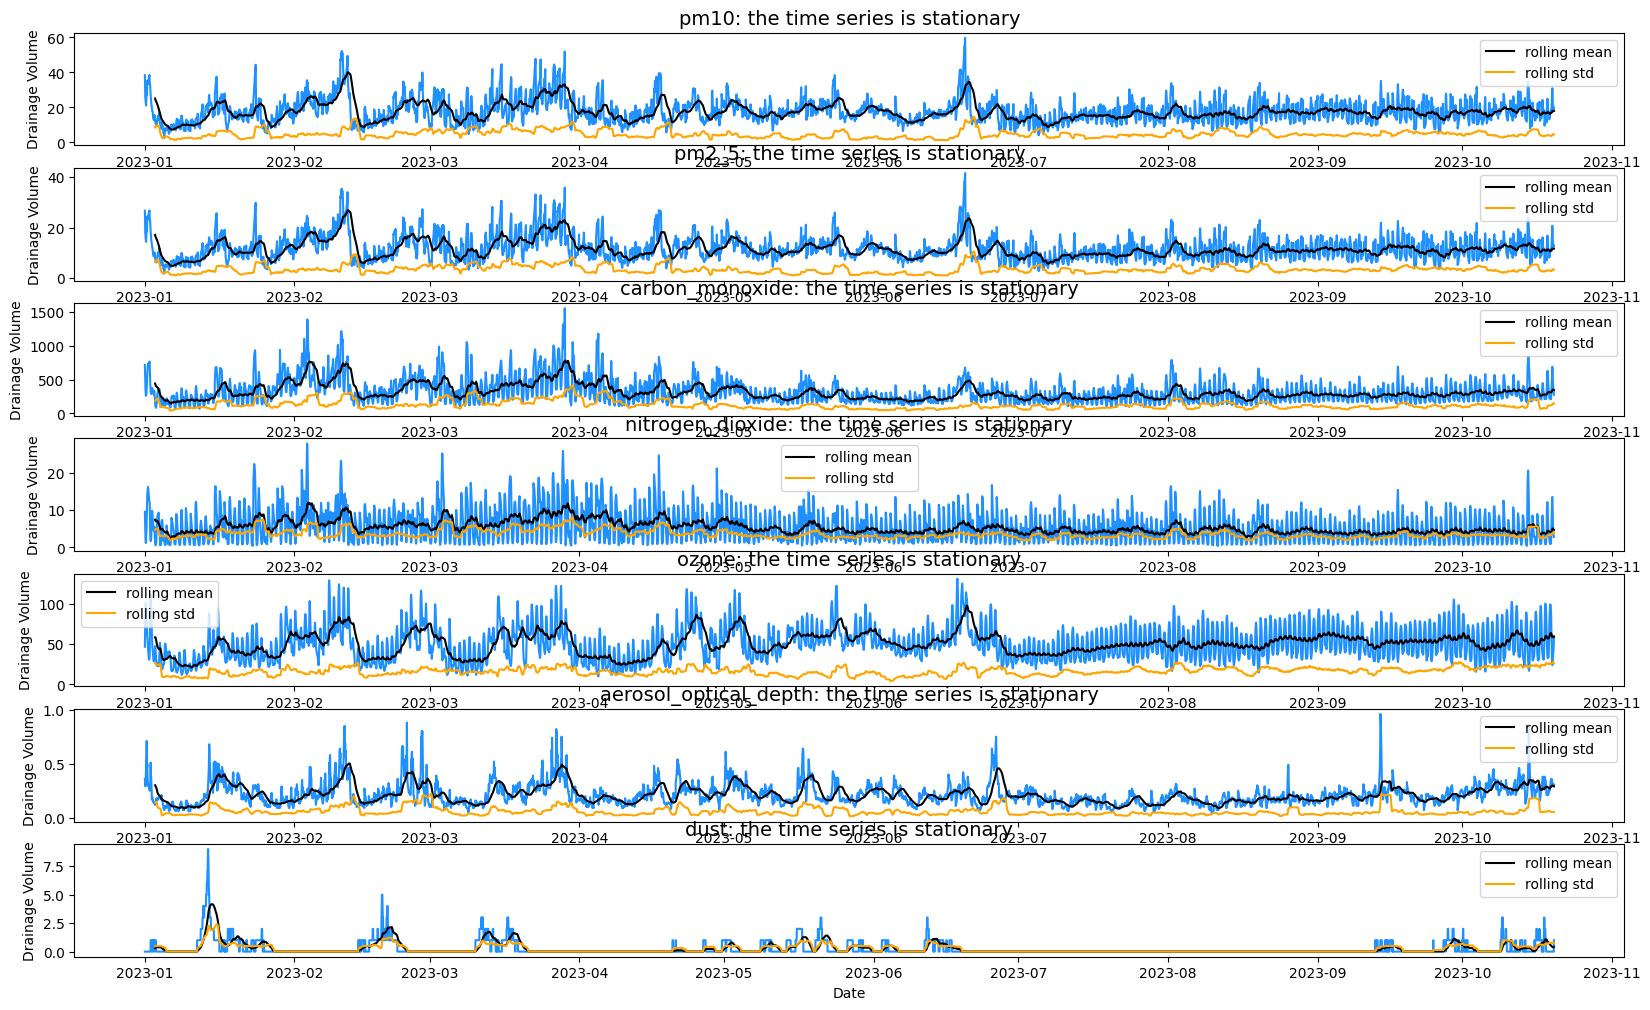

In [10]:
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import pandas as pd

def plot_rolling_statistics(df: pd.DataFrame, rolling_window=7):
    """
    Plot rolling statistics for a given DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
        rolling_window (int, optional): Rolling window size for mean and std calculations. Defaults to 7.

    Returns:
        None: This function displays the plot but doesn't return any value.
    """
    numerical_features = df.select_dtypes(include=np.number).columns
    f, ax = plt.subplots(nrows=len(numerical_features), ncols=1, figsize=(20, 12))
    
    for i, feat in enumerate(numerical_features):
        sns.lineplot(x=df['time'], y=df[feat], ax=ax[i], color='dodgerblue')
        sns.lineplot(x=df['time'], y=df[feat].rolling(rolling_window).mean(), ax=ax[i], color='black', label='rolling mean')
        sns.lineplot(x=df['time'], y=df[feat].rolling(rolling_window).std(), ax=ax[i], color='orange', label='rolling std')
        
        # Calculate ADF test results
        adf_result = adfuller(df[feat], autolag="AIC")
        if adf_result[1] <= 0.05:
            ax[i].set_title(f'{feat}: the time series is stationary', fontsize=14)
        else:
            ax[i].set_title(f'{feat}: the time series is non-stationary', fontsize=14)

        # Add labels and legend
        ax[i].set_xlabel('Date')
        ax[i].set_ylabel('Drainage Volume')
        ax[i].legend()

    # Show the plot
    plt.show()

# Example usage:
plot_rolling_statistics(data,52)

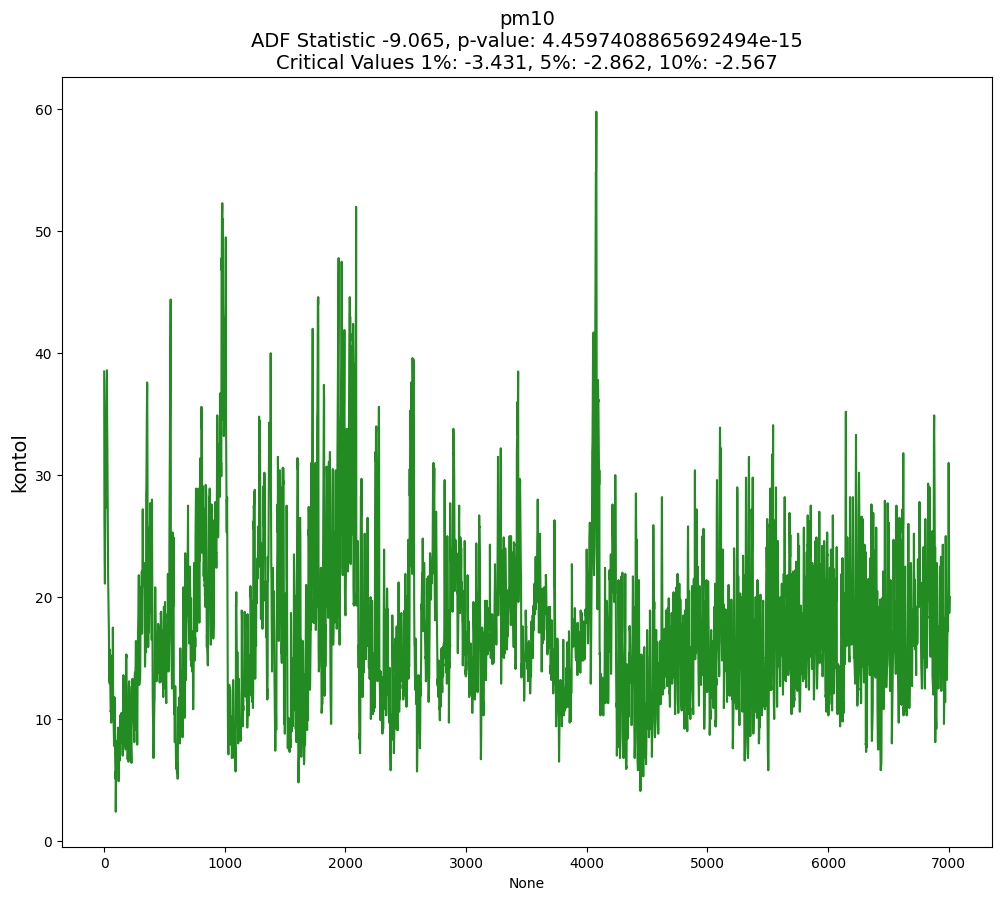

In [11]:
visualize_adfuller_results(data,"pm10","kontol")

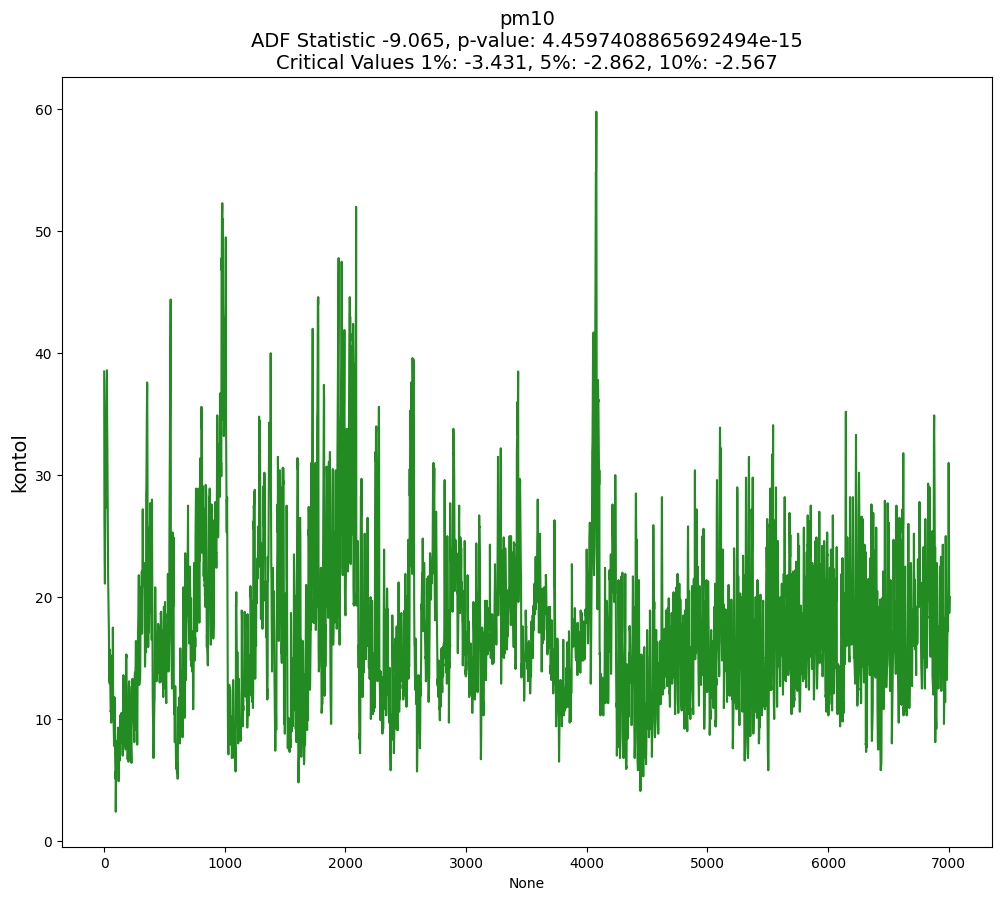

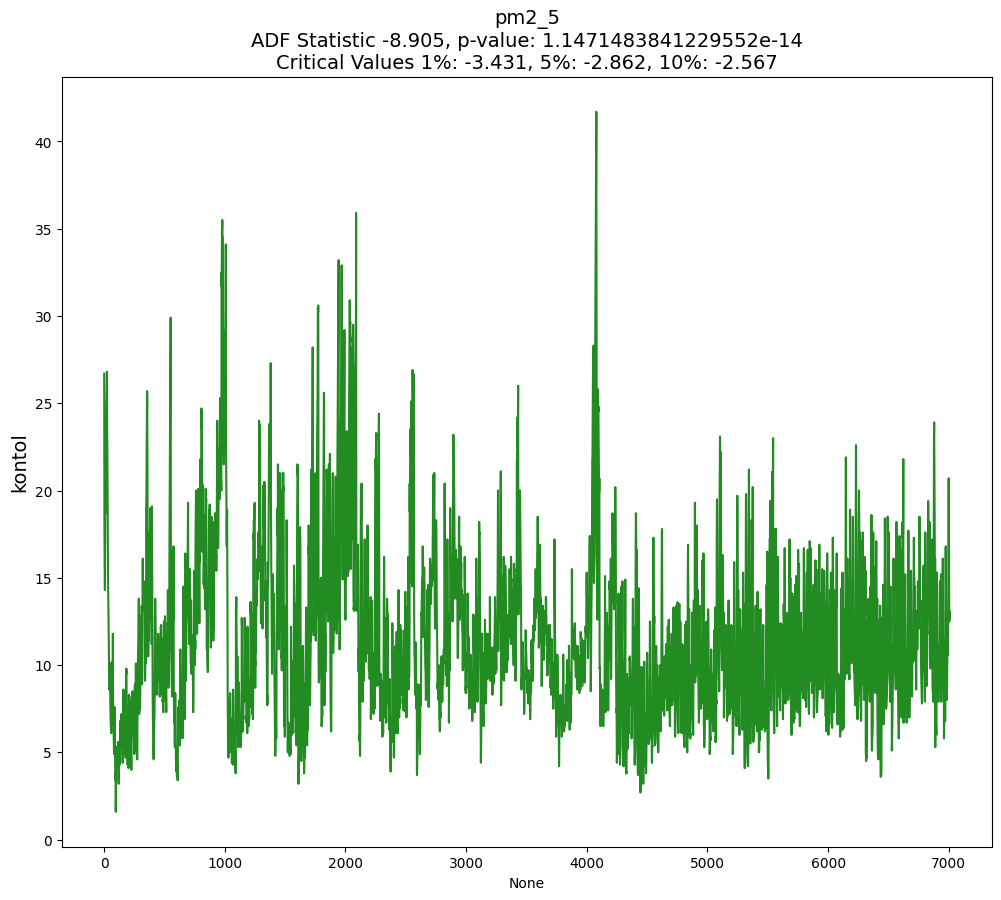

In [12]:
visualize_adfuller_results(data,["pm10","pm2_5"],"kontol")

## Data Preprocessing

#### - For Clustering Model

In [13]:
data_cluster = data.set_index("time").resample("D").mean()
data_cluster.reset_index().drop(["time"],axis=1,inplace=True)

### Scaling Data

In [14]:
from sklearn.preprocessing import StandardScaler
pre_data = StandardScaler().fit_transform(data_cluster)

#### Modeling Data

In [15]:
from Tengai.model import dbscan_grid_search
_,_,_,best_parameter=dbscan_grid_search(pre_data)
best_parameter

(0.5, 6)

In [16]:
from sklearn.cluster import DBSCAN,KMeans
cluster = DBSCAN(eps=best_parameter[0],min_samples=best_parameter[1])
best_clusters = cluster.fit_predict(X=pre_data)

The best number of clusters is: 6
Cluster Assignments:
Noise points: 233
Cluster 0: 14 data points
Cluster 1: 7 data points
Cluster 2: 7 data points
Cluster 3: 13 data points
Cluster 4: 4 data points
Cluster 5: 14 data points


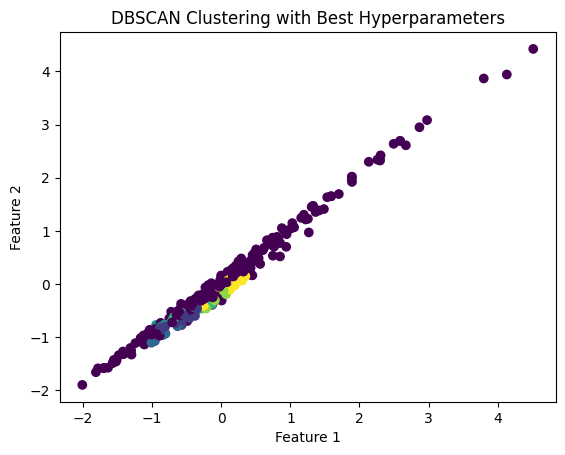

In [17]:
best_n_clusters = len(np.unique(best_clusters)) - 1
print(f"The best number of clusters is: {best_n_clusters}")

# Example: Print cluster assignments
print("Cluster Assignments:")
for label in np.unique(best_clusters):
    if label == -1:
        print(f"Noise points: {np.sum(best_clusters == label)}")
    else:
        print(f"Cluster {label}: {np.sum(best_clusters == label)} data points")

# Example: Visualize the clusters (you may use a suitable visualization library)
# This depends on the structure of your data and how you want to visualize it.
# For example, you can create a scatter plot using Matplotlib or Seaborn.
# Here's a basic example using Matplotlib:
import matplotlib.pyplot as plt
plt.scatter(pre_data[:, 0], pre_data[:, 1], c=best_clusters)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('DBSCAN Clustering with Best Hyperparameters')
plt.show()

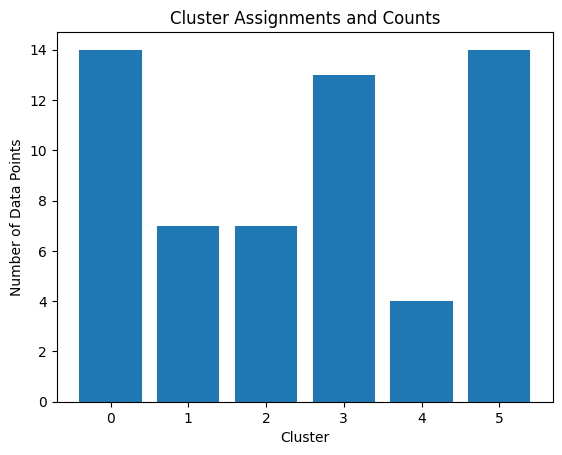

In [18]:
unique_clusters, cluster_counts = np.unique(best_clusters, return_counts=True)
unique_clusters = unique_clusters[1:]
cluster_counts = cluster_counts[1:]
plt.bar(unique_clusters, cluster_counts)
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.title('Cluster Assignments and Counts')
plt.show()

c:\Users\iqbal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


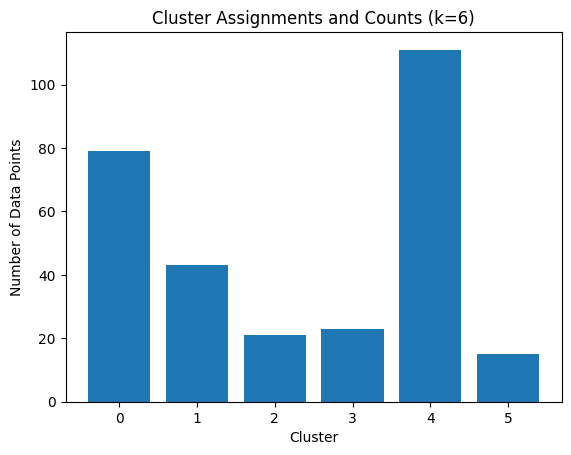

In [19]:
kmeans = KMeans(n_clusters=6,random_state=42,init="random",max_iter=100)
cluster_assignments = kmeans.fit_predict(pre_data)

# Count the number of data points in each cluster
unique_clusters, cluster_counts = np.unique(cluster_assignments, return_counts=True)

# Create a bar plot
plt.bar(unique_clusters, cluster_counts)
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.title(f'Cluster Assignments and Counts (k={6})')
plt.show()

In [20]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
# Evaluate K-Means clustering using Silhouette Score and Davies-Bouldin Index
kmeans_silhouette = silhouette_score(pre_data, cluster_assignments)
kmeans_db_index = davies_bouldin_score(pre_data, cluster_assignments)

# Evaluate DBSCAN clustering using Silhouette Score and Davies-Bouldin Index
dbscan_silhouette = silhouette_score(pre_data, best_clusters)
dbscan_db_index = davies_bouldin_score(pre_data, best_clusters)


In [21]:
print(f'K-Means Silhouette Score: {kmeans_silhouette}')
print(f'K-Means Davies-Bouldin Index: {kmeans_db_index}')
print(f'DBSCAN Silhouette Score: {dbscan_silhouette}')
print(f'DBSCAN Davies-Bouldin Index: {dbscan_db_index}')

K-Means Silhouette Score: 0.24542907305110764
K-Means Davies-Bouldin Index: 1.1547689544137123
DBSCAN Silhouette Score: -0.24911145634915363
DBSCAN Davies-Bouldin Index: 1.661944226086376


In [22]:
import joblib
with open("cluster_mode.pkl","wb") as f:
    joblib.dump(kmeans,f)

In [23]:
load_cluster = joblib.load("cluster_mode.pkl")

In [24]:
with open("cluster_mode.pkl", "rb") as f:
    cluster_assignments = joblib.load(f)

In [25]:
cluster_assignments = cluster_assignments.predict(pre_data)

In [26]:
cluster_assignments

array([5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 1, 1, 4, 3, 3, 3, 0, 0,
       2, 3, 0, 0, 0, 2, 2, 1, 4, 1, 2, 5, 1, 4, 2, 1, 1, 5, 5, 5, 1, 0,
       0, 0, 0, 0, 3, 3, 3, 3, 4, 5, 1, 1, 2, 1, 4, 4, 1, 2, 0, 0, 0, 0,
       2, 2, 0, 3, 3, 1, 1, 5, 3, 3, 3, 1, 2, 1, 5, 5, 5, 1, 5, 5, 5, 1,
       2, 4, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 4, 0, 4,
       1, 4, 1, 1, 1, 4, 0, 4, 2, 2, 1, 1, 1, 1, 4, 4, 0, 0, 4, 4, 0, 0,
       4, 4, 4, 3, 1, 1, 4, 3, 3, 4, 1, 1, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4,
       4, 4, 0, 0, 0, 0, 0, 4, 3, 4, 4, 4, 4, 1, 1, 5, 1, 4, 0, 4, 4, 1,
       1, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0,
       4, 0, 0, 4, 0, 4, 4, 4, 4, 0, 4, 0, 4, 4, 2, 1, 4, 0, 0, 0, 4, 4,
       4, 4, 4, 4, 4, 4, 0, 0, 4, 0, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 1, 4, 4, 4, 4, 4, 4, 0,
       4, 4, 4, 0, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 3, 4, 4, 1, 4,
       1, 4, 3, 4, 4, 1])

In [27]:
label = {"good","fair","moderator","poor","very poor","Extremely poor"}
zipping = dict(zip(np.unique(kmeans.labels_),label))

In [28]:
import json
data_to_write = {str(key): value for key, value in zipping.items()}
with open("label_cluster.json","w") as f:
    json.dump(data_to_write,f)


In [29]:
with open('label_cluster.json', 'r') as file:
    # Load JSON data from the file
    label = json.load(file)

# Time Series Data preprocessing

In [98]:
times_series_df = data.set_index("time")
times_series_df = times_series_df.resample("D").mean().round(3)
times_series_df

,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,ozone,aerosol_optical_depth,dust
time,,,,,,,
2023-01-01,31.179,21.467,554.750,9.929,61.458,0.387,0.000
2023-01-02,20.875,14.025,365.792,5.804,59.625,0.242,0.500
2023-01-03,12.717,8.242,226.167,5.238,30.375,0.160,0.333
2023-01-04,9.517,6.112,169.750,3.404,30.542,0.157,0.000
2023-01-05,7.117,4.492,157.417,2.138,39.958,0.103,0.000
...,...,...,...,...,...,...,...
2023-10-15,14.250,9.358,252.500,3.658,50.167,0.287,0.042
2023-10-16,17.496,11.321,278.167,3.796,55.125,0.261,1.083
2023-10-17,16.767,10.996,290.333,4.033,58.458,0.272,0.833


In [107]:
time_series_feature = times_series_df["pm10"]
train_data = time_series_feature[time_series_feature.index < '2023-10-10']
valid_data = time_series_feature[time_series_feature.index >= '2023-10-10']

In [116]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = pd.DataFrame(train_data, columns=['pm10'])
valid_data = pd.DataFrame(valid_data, columns=['pm10'])

train_data['pm10'] = scaler.fit_transform(train_data[['pm10']])
valid_data['pm10'] = scaler.transform(valid_data[['pm10']])

In [117]:
def create_sequences(data, sequence_length):
    sequences = []
    targets = []

    for i in range(len(data) - sequence_length):
        sequence = data[i:i+sequence_length]
        target = data.iloc[i+sequence_length]['pm10']
        sequences.append(sequence)
        targets.append(target)

    return np.array(sequences), np.array(targets)

sequence_length = 10  # Sesuaikan dengan panjang sekuens yang Anda inginkan
X_train, y_train = create_sequences(train_data, sequence_length)
X_valid, y_valid = create_sequences(valid_data, sequence_length)


In [118]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

ModuleNotFoundError: No module named 'tensorflow'